In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from pypeit.specutils import Spectrum1D
from pypeit.specutils import SpectrumList
from pypeit.core import wave

from specutils.manipulation import (box_smooth,
                                    gaussian_smooth,
                                    trapezoid_smooth)

from astropy import units as u
from astropy.table import Table
from astropy.visualization import quantity_support
from astropy.coordinates import SkyCoord
from astropy.time import Time
import os
from glob import glob
import pandas as pd
import urllib.request as ureq

quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f252182d150>

In [2]:
url = 'https://classic.sdss.org/dr6/algorithms/linestable.php'

uf = ureq.urlopen(url)
html = uf.read()

tables = pd.read_html(str(url), flavor='html5lib',header=1)[0]

In [3]:
lines = tables.iloc[1:37]
lines['Galaxy'] = lines['Galaxy'].astype(float)
lines['vac (Å)'] = lines['vac (Å)'].astype(float)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy (214283649.py:2)
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy (214283649.py:3)


In [4]:
gal_em = lines[lines['Galaxy']>0]
gal_em['SPECIES'] = ['Mg II', 'O II', r'H$\Delta$', r'H$\gamma$', r'H$\beta$', 'O III', 'O III', 'N II', r'H$\alpha$','N II', 'S II', 'S II']
tmp = pd.DataFrame({'vac (Å)':[3729],'Galaxy':[1],'Quasar':[0],'SPECIES':['O II']})
gal_em = pd.concat((gal_em,tmp)).reset_index(drop=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy (4132517119.py:2)


In [5]:
gal_em

vac (Å)  Galaxy Quasar    SPECIES
0   2799.117     1.0    8.0      Mg II
1   3727.092     5.0    1.0       O II
2   4102.890     0.5    2.0  H$\Delta$
3   4341.680     1.0    3.0  H$\gamma$
4   4862.680     2.0    4.0   H$\beta$
5   4960.295     2.0    2.0      O III
6   5008.240     3.0    2.0      O III
7   6549.860     3.0    0.0       N II
8   6564.610     8.0    8.0  H$\alpha$
9   6585.270     3.0    0.0       N II
10  6718.290     3.0    0.0       S II
11  6732.670     3.0    0.0       S II
12  3729.000     1.0      0       O II

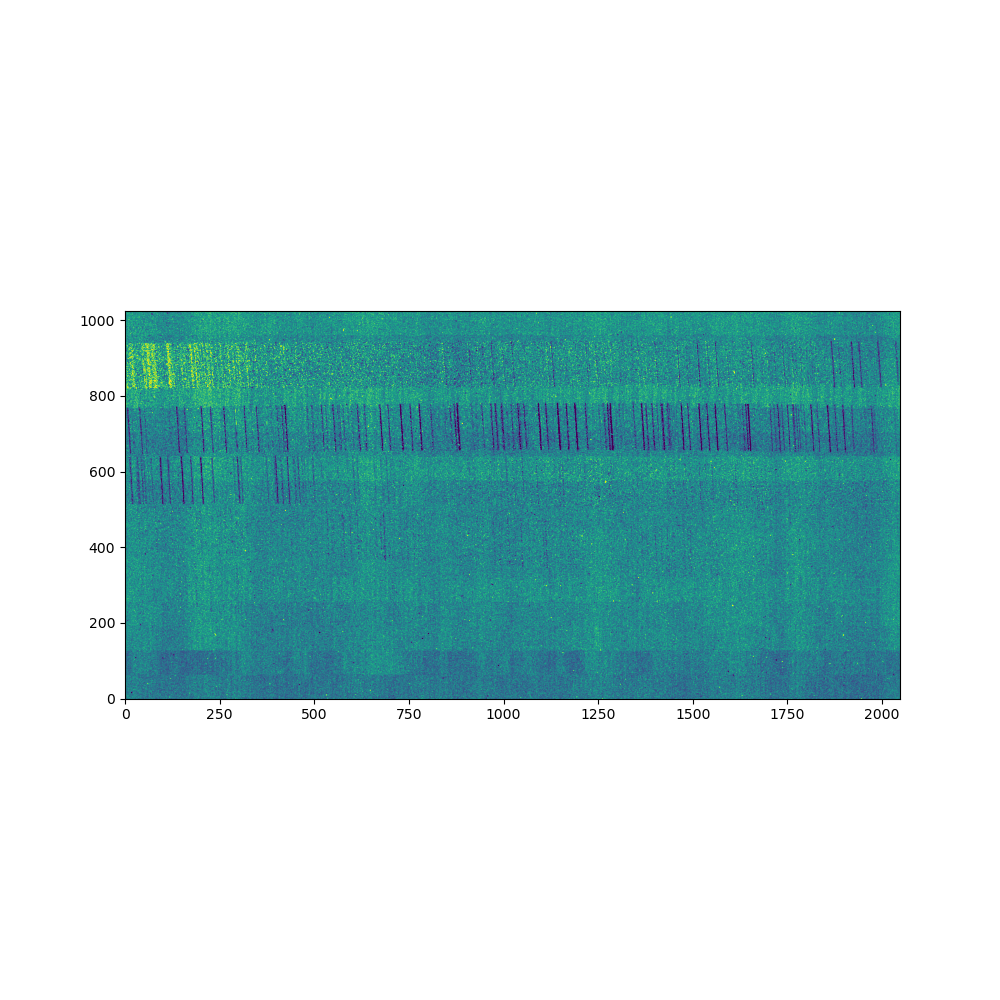

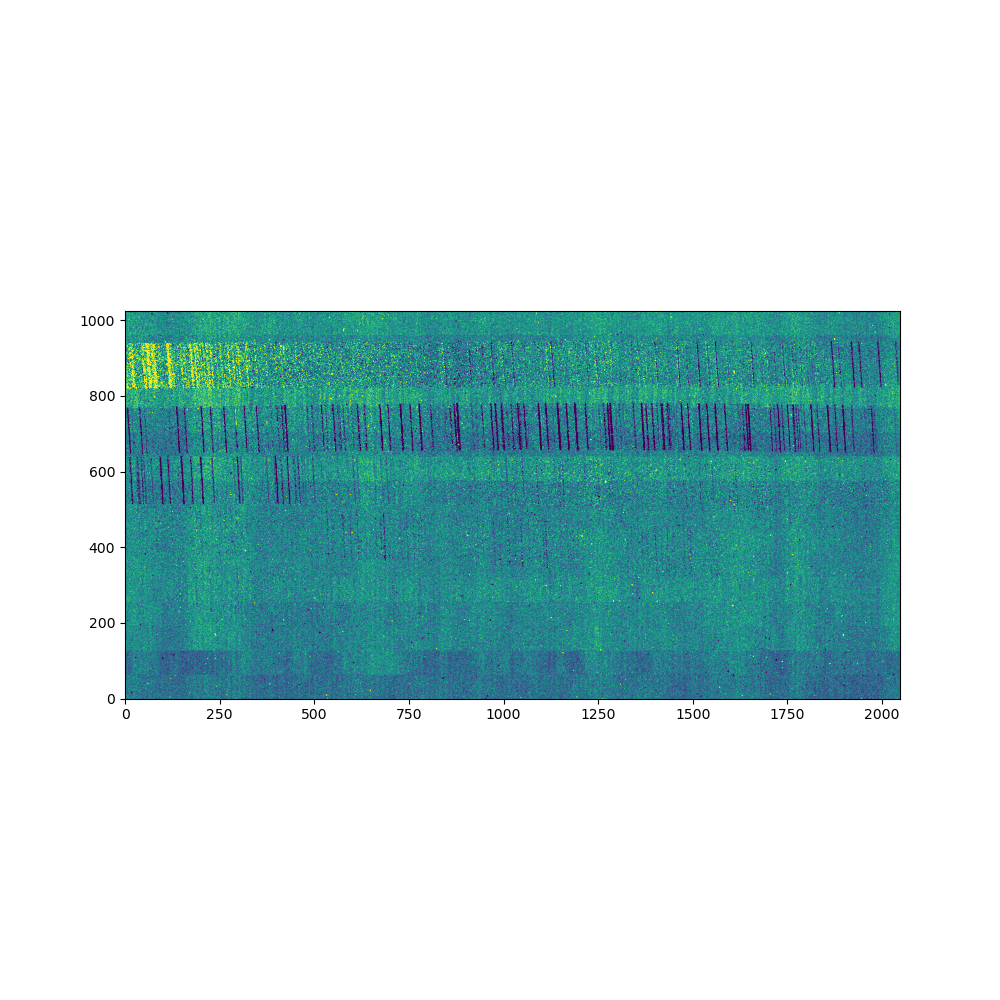

In [43]:
%matplotlib widget
sys_files = sorted(glob('/home/tamar/findinglens/keck/2023-11-21/DESI-072/raw_data/*.fits'.format('s')))
# sys_files = sorted(glob('/home/tamar/findinglens/keck/2023-01-11/DESI215/raw_data/*.fits'.format('s')))
li =[]
for f in sys_files:
    if 'DESI-072' in fits.getheader(f)['OBJECT']:
        hdu = fits.open(f)
        li.append(hdu[0].data)
        
B = li[1] + li[2] + li[5] + li[6] 
A = li[0] + li[3] + li[4] + li[7]

# B = li[1] + li[2]
# A = li[0] + li[3]

plt.figure(figsize=(10,10))
plt.imshow(np.arcsinh(B-A), vmin=-15/3, vmax=15/3)
plt.gca().invert_yaxis()
plt.show()

B1 = np.median((li[1],li[2]),axis=0)
B2 = np.median((li[5],li[6]),axis=0)

A1 = np.median((li[0],li[3]),axis=0)
A2 = np.median((li[4],li[7]),axis=0)

B = B1+B2
A = A1+A2

# B=B1
# A=A1

img = B-A

plt.figure(figsize=(10,10))
plt.imshow(np.arcsinh(img),vmin=-15/5,vmax=15/5)
plt.gca().invert_yaxis()
# plt.scatter(680.78,538.66)
# plt.xlim(680-100, 680+100)
# plt.ylim(538-100, 538+100)
plt.show()

In [42]:
fits.PrimaryHDU(img).writeto('/home/tamar/findinglens/keck/plot_images/desi072_2dspec_coadd.fits')

In [8]:
raw1d = glob('/home/tamar/findinglens/keck/2024-04-27/DESI-257_31/reducing_folder/keck_nires_A/Science/*spec1*DESI*.fits')
raw1d

['/home/tamar/findinglens/keck/2024-04-27/DESI-257_31/reducing_folder/keck_nires_A/Science/spec1d_NR.20240427.48347.22-DESI-257_31_NIRES_20240427T132547.221.fits',
 '/home/tamar/findinglens/keck/2024-04-27/DESI-257_31/reducing_folder/keck_nires_A/Science/spec1d_NR.20240427.48707.31-DESI-257_31_NIRES_20240427T133147.311.fits']

In [9]:
fwv_li, ffx_li =[],[]
for f in [raw1d[0]]:
    print(f)
    wv_li, cnt_li=[],[]
    for i in range(1,6):
        wvf = Table.read(f, hdu=i)['OPT_WAVE']
        cnts = Table.read(f, hdu=i)['OPT_COUNTS']
        wv_li.append(wvf)
        cnt_li.append(cnts)
        wv = np.array(wv_li).flatten()
        fx = np.array(cnt_li).flatten()
    fwv_li.append(wv)
    ffx_li.append(fx)

/home/tamar/findinglens/keck/2024-04-27/DESI-257_31/reducing_folder/keck_nires_A/Science/spec1d_NR.20240427.48347.22-DESI-257_31_NIRES_20240427T132547.221.fits


(-0.05, 1.0)

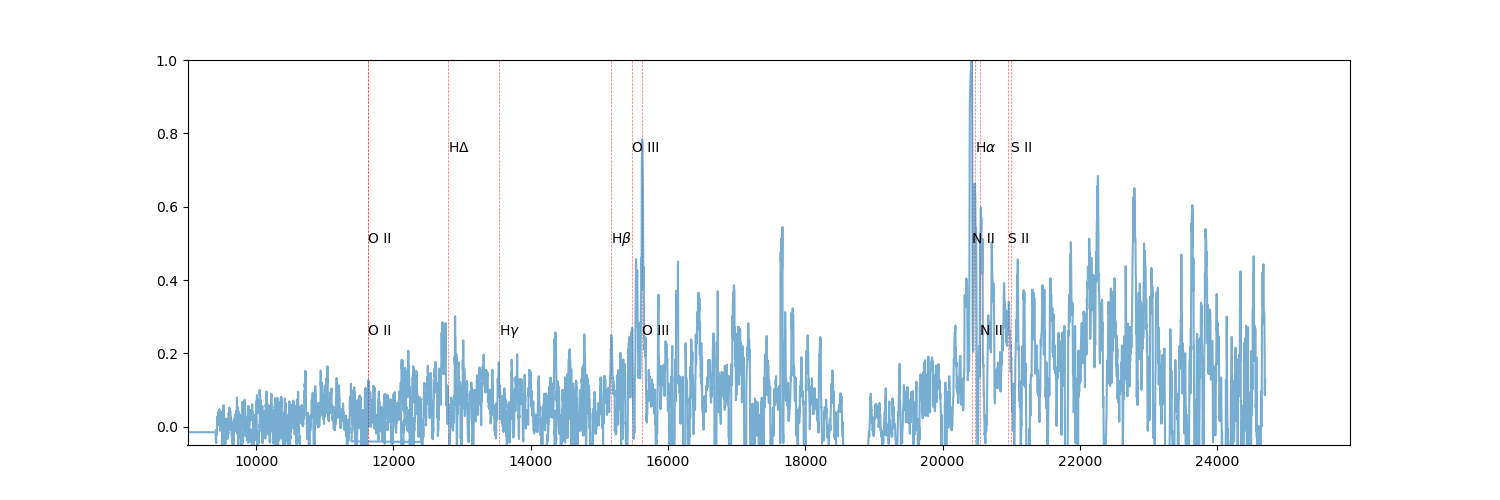

In [10]:
smth = 15
z = 2.119
plt.figure(figsize=(15,5))

for i,row in gal_em.iterrows():
    plt.plot([row['vac (Å)']*(1+z),row['vac (Å)']*(1+z)],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    plt.annotate(xy=(row['vac (Å)']*(1+z),0.25+(0.25*(i%3))),text=row['SPECIES'])

sfx2 = np.convolve(np.median(ffx_li, axis=0), np.ones(smth)/smth, 'same')
plt.plot(wv, sfx2/sfx2.max(), alpha=0.6)
plt.xlim(9000,)
plt.ylim(-0.05, 1)

In [11]:
telat = 19.8263
tellon = -155.47441

In [12]:
# teldec = 0.371936870713444
# telaz =  136.679922764453
telel = 4145

In [13]:
coords = SkyCoord(246.0062, 01.4836, unit='deg')

t = Time(60427.5948106627 , format='mjd')

In [14]:
wave.geomotion_correct(coords,t,tellon, telat, telel, refframe='barycentric')


(12.289120670947657, 1.0000409929343843)

In [15]:
# specf = glob('/home/tamar/findinglens/keck/2023-11-21/DESI-004/reducing_folder/keck_nires_A/*DESI*')
# specf = glob('/home/tamar/findinglens/DESI006/reducing_folder/keck_nires_A/*DESI*')
specf = glob('/home/tamar/findinglens/keck/2023-11-21/DESI-072/reduing_folder/keck_nires_B/*DESI*')
specf.sort()
# specg.sort()
specf

['/home/tamar/findinglens/keck/2023-11-21/DESI-072/reduing_folder/keck_nires_B/DESI-072_coadd.fits']

[WARNING] :: Wavelengths are not monotonically increasing!  Strict was set to False, so measurements after a negative step in wavelength are removed from the constructed spectrum.  BEWARE that this is likely the result of an error in the data reduction!
[WARNING] :: Wavelengths are not monotonically increasing!  Strict was set to False, so measurements after a negative step in wavelength are removed from the constructed spectrum.  BEWARE that this is likely the result of an error in the data reduction!


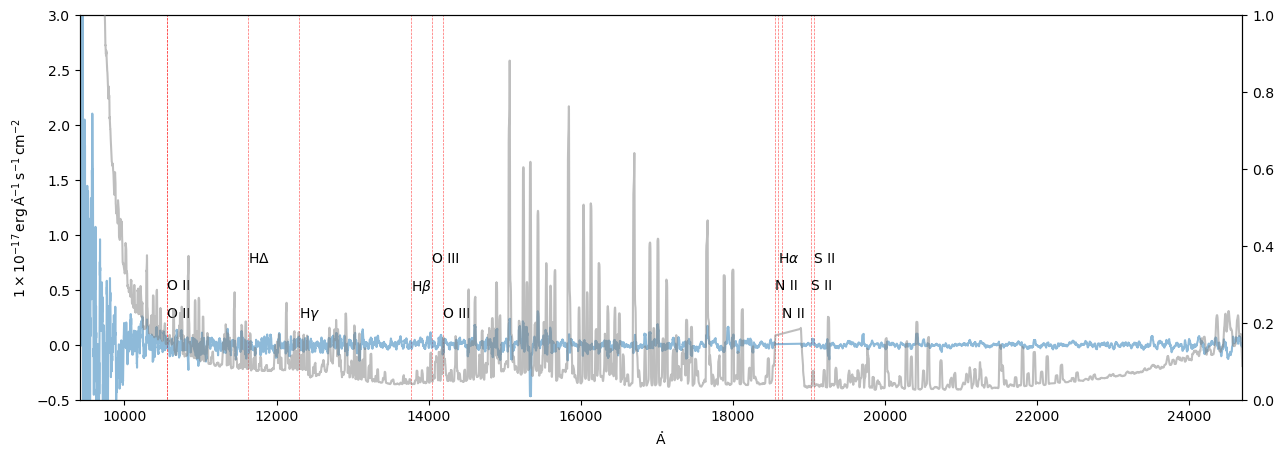

In [23]:
spec = Spectrum1D.read(specf[0], strict=False)
spec_tellcor = Spectrum1D.read(specf[0], strict=False)


%matplotlib inline
smth = 10
z = 1.832
wv = wave.airtovac(spec.spectral_axis)
fx = spec.flux
err = spec.uncertainty

fwv = wv[wv>0]
ffx = fx[wv>0]
ferr = err[wv>0].array

tellcor_wv = wave.airtovac(spec_tellcor.spectral_axis)
tellcor_fx = spec_tellcor.flux
tellcor_err = spec_tellcor.uncertainty

tellcor_fwv = tellcor_wv[tellcor_wv>0]
tellcor_ffx = tellcor_fx[tellcor_wv>0]
tellcor_ferr = tellcor_err[tellcor_wv>0].array


fig, ax = plt.subplots(1,1, figsize=(15,5))


sfx3 = np.convolve(ffx, np.ones(smth)/smth, 'same')
sferr = np.convolve(ferr, np.ones(smth)/smth, 'same')
sf_tellcor = np.convolve(tellcor_ffx, np.ones(smth)/smth, 'same')
tellcor_ferr_sm = np.convolve(tellcor_ferr, np.ones(smth)/smth, 'same')


# ax.plot(fwv[2:],sfx3[2:]-sf_tellcor[:], linewidth=1.5, zorder=20, alpha=0.8, color='tab:green')
ax.plot(fwv,sfx3, linewidth=1.5, zorder=20, alpha=0.5, color='tab:blue')
secax = ax.twinx()
# ax.plot(tellcor_fwv, sf_tellcor, linewidth=1.5, zorder=20, alpha=0.5, color='tab:red')
secax.plot(fwv,sferr, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
secax.set_ylim(0,1)
# ax.plot(tellcor_fwv,tellcor_ferr_sm, linewidth=1.5, zorder=20, alpha=0.5, color='tab:orange')


# plt.plot(spec1_gsmooth.spectral_axis, spec1_gsmooth.flux, linewidth=1.5, zorder=20, alpha=0.8)



for i,row in gal_em.iterrows():
    ax.plot([row['vac (Å)']*(1+z),row['vac (Å)']*(1+z)],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    ax.annotate(xy=(row['vac (Å)']*(1+z),0.25+(0.25*(i%3))),text=row['SPECIES'])
    
    # ax[1].plot([row['vac (Å)']*(1+z),row['vac (Å)']*(1+z)],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    # ax[1].annotate(xy=(row['vac (Å)']*(1+z),0.25+(0.5*(i%3))),text=row['SPECIES'])


ax.set_ylim(-0.5, 3)
ax.set_xlim(fwv.min(),fwv.max())
# ax.set_xlim(12000, fwv.max())
# ax.set_xlim(22049-250,22049+250)

# ax[1].set_ylim(-0.5, 1.5)
# ax[1].set_xlim(15000,fwv.max())
# ax[1].set_xlim(20500-550, 20500+550)



plt.show()

In [24]:
1.7401 - 1.7396

0.0004999999999999449

In [25]:
1.7386 - 1.7379

0.0006999999999999229

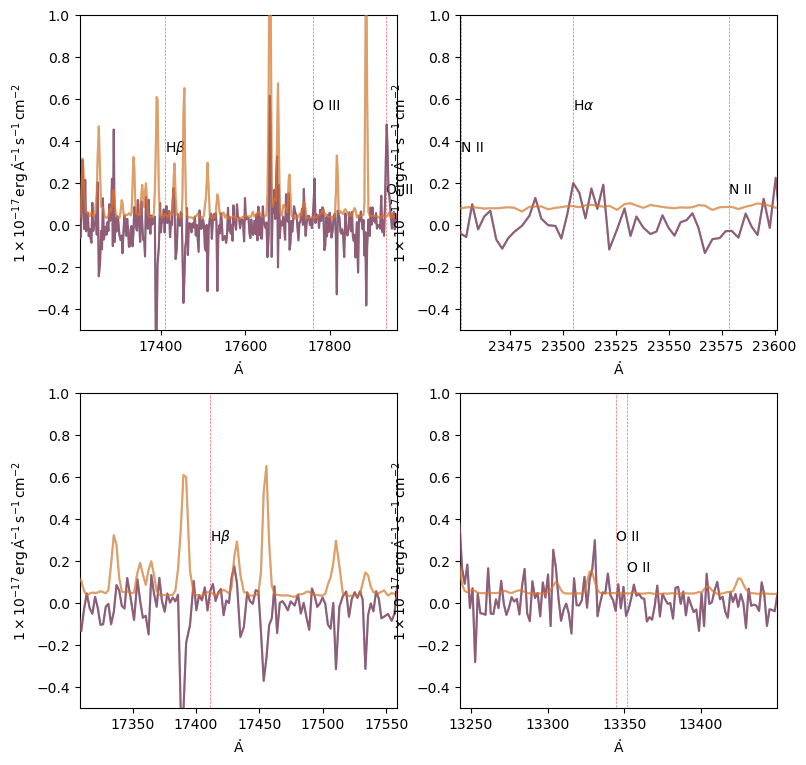

In [37]:
fig, ax = plt.subplots(2,2, figsize=(9,9))

z= 2.5805

redshifted = gal_em[['vac (Å)']] * (2.58+1)

%matplotlib inline
smth = 1

sfx3 = np.convolve(ffx, np.ones(smth)/smth, 'same')
sferr = np.convolve(ferr, np.ones(smth)/smth, 'same')
sf_tellcor = np.convolve(tellcor_ffx, np.ones(smth)/smth, 'same')
tellcor_ferr_sm = np.convolve(tellcor_ferr, np.ones(smth)/smth, 'same')


ax[0][0].plot(fwv,sfx3, linewidth=1.5, zorder=20, alpha=0.8, color='tab:blue', label='2023-01-11')
ax[0][0].plot(fwv,sferr, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
ax[0][0].plot(tellcor_fwv, sf_tellcor, linewidth=1.5, zorder=20, alpha=0.5, color='tab:red', label='2024-04-27')
ax[0][0].plot(tellcor_fwv, tellcor_ferr_sm, linewidth=1.5, zorder=20, alpha=0.5, color='tab:orange')
# ax[0][0].axvline(21089)


ax[0][1].plot(fwv,sfx3, linewidth=1.5, zorder=20, alpha=0.8, color='tab:blue', label='2023-01-11')
ax[0][1].plot(fwv,sferr, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
ax[0][1].plot(tellcor_fwv, sf_tellcor, linewidth=1.5, zorder=20, alpha=0.5, color='tab:red', label='2024-04-27')
ax[0][1].plot(tellcor_fwv,tellcor_ferr_sm, linewidth=1.5, zorder=20, alpha=0.5, color='tab:orange')

ax[1][0].plot(fwv,sfx3, linewidth=1.5, zorder=20, alpha=0.8, color='tab:blue', label='2023-01-11')
ax[1][0].plot(fwv,sferr, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
ax[1][0].plot(tellcor_fwv, sf_tellcor, linewidth=1.5, zorder=20, alpha=0.5, color='tab:red', label='2024-04-27')
ax[1][0].plot(tellcor_fwv,tellcor_ferr_sm, linewidth=1.5, zorder=20, alpha=0.5, color='tab:orange')

ax[1][1].plot(fwv,sfx3, linewidth=1.5, zorder=20, alpha=0.8, color='tab:blue', label='2023-01-11')
ax[1][1].plot(fwv,sferr, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
ax[1][1].plot(tellcor_fwv, sf_tellcor, linewidth=1.5, zorder=20, alpha=0.5, color='tab:red', label='2024-04-27')
ax[1][1].plot(tellcor_fwv,tellcor_ferr_sm, linewidth=1.5, zorder=20, alpha=0.5, color='tab:orange')

for i,row in gal_em.iterrows():
    ax[0][0].plot([row['vac (Å)']*(1+z),row['vac (Å)']*(1+z)],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    ax[0][0].annotate(xy=(row['vac (Å)']*(1+z),0.15+(0.2*(i%3))),text=row['SPECIES'])
    
    ax[0][1].plot([row['vac (Å)']*(1+z),row['vac (Å)']*(1+z)],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    ax[0][1].annotate(xy=(row['vac (Å)']*(1+z),0.15+(0.2*(i%3))),text=row['SPECIES'])
    
    ax[1][0].plot([row['vac (Å)']*(1+z),row['vac (Å)']*(1+z)],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    ax[1][0].annotate(xy=(row['vac (Å)']*(1+z),0.15+(0.15*(i%3))),text=row['SPECIES'])
    
    ax[1][1].plot([row['vac (Å)']*(1+z),row['vac (Å)']*(1+z)],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    ax[1][1].annotate(xy=(row['vac (Å)']*(1+z),0.15+(0.15*(i%3))),text=row['SPECIES'])


ax[0][0].set_ylim(-0.5, 1)
ax[0][0].set_xlim(11000,fwv.max())
ax[0][0].set_xlim(redshifted.values[4]-200,redshifted.values[5]+200)
# ax[0][0].set_xlim(6550-10, 6565+100)

ax[0][1].set_ylim(-0.5, 1)
# ax[1].set_xlim(11000,fwv.max())
ax[0][1].set_xlim(redshifted.values[8]-50,redshifted.values[8]+100)
# ax[1].set_xlim(4960-150,5008+150)
                
ax[1][0].set_ylim(-0.5, 1)
ax[1][0].set_xlim(11000,fwv.max())
ax[1][0].set_xlim(redshifted.values[4]-100,redshifted.values[4]+150)

ax[1][1].set_ylim(-0.5, 1)
ax[1][1].set_xlim(10558, 10658)
ax[1][1].set_xlim(redshifted.values[1]-100,redshifted.values[12]+100)

# ax[0][0].legend()
# ax[0][1].legend()
# ax[1][0].legend()
# ax[1][1].legend()


plt.show()

In [36]:
gal_em['vac (Å)'][8] * (1+2.5805)

23504.586105

In [21]:
gal_em

vac (Å)  Galaxy Quasar    SPECIES
0   2799.117     1.0    8.0      Mg II
1   3727.092     5.0    1.0       O II
2   4102.890     0.5    2.0  H$\Delta$
3   4341.680     1.0    3.0  H$\gamma$
4   4862.680     2.0    4.0   H$\beta$
5   4960.295     2.0    2.0      O III
6   5008.240     3.0    2.0      O III
7   6549.860     3.0    0.0       N II
8   6564.610     8.0    8.0  H$\alpha$
9   6585.270     3.0    0.0       N II
10  6718.290     3.0    0.0       S II
11  6732.670     3.0    0.0       S II
12  3729.000     1.0      0       O II